In [1]:
import warnings
warnings.filterwarnings("ignore")

import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import multiprocessing
import torchvision
import timm
import os
from transformers import *
from datasets import load_dataset
from PIL import Image
from torchinfo import summary
from torch import nn
from torch.utils.tensorboard import SummaryWriter
from tqdm.auto import tqdm
import time

torch.cuda.empty_cache()
device="cuda" if torch.cuda.is_available() else "cpu"

WARNING[XFORMERS]: xFormers can't load C++/CUDA extensions. xFormers was built for:
    PyTorch 2.1.0+cu121 with CUDA 1201 (you have 2.0.1+cu117)
    Python  3.9.18 (you have 3.9.17)
  Please reinstall xformers (see https://github.com/facebookresearch/xformers#installing-xformers)
  Memory-efficient attention, SwiGLU, sparse and more won't be available.
  Set XFORMERS_MORE_DETAILS=1 for more details


### Loading in data and pretrained model

In [2]:
timm.list_models("vit*",pretrained=True)

['vit_base_patch8_224.augreg2_in21k_ft_in1k',
 'vit_base_patch8_224.augreg_in21k',
 'vit_base_patch8_224.augreg_in21k_ft_in1k',
 'vit_base_patch8_224.dino',
 'vit_base_patch14_dinov2.lvd142m',
 'vit_base_patch16_224.augreg2_in21k_ft_in1k',
 'vit_base_patch16_224.augreg_in1k',
 'vit_base_patch16_224.augreg_in21k',
 'vit_base_patch16_224.augreg_in21k_ft_in1k',
 'vit_base_patch16_224.dino',
 'vit_base_patch16_224.mae',
 'vit_base_patch16_224.orig_in21k_ft_in1k',
 'vit_base_patch16_224.sam_in1k',
 'vit_base_patch16_224_miil.in21k',
 'vit_base_patch16_224_miil.in21k_ft_in1k',
 'vit_base_patch16_384.augreg_in1k',
 'vit_base_patch16_384.augreg_in21k_ft_in1k',
 'vit_base_patch16_384.orig_in21k_ft_in1k',
 'vit_base_patch16_clip_224.datacompxl',
 'vit_base_patch16_clip_224.laion2b',
 'vit_base_patch16_clip_224.laion2b_ft_in1k',
 'vit_base_patch16_clip_224.laion2b_ft_in12k',
 'vit_base_patch16_clip_224.laion2b_ft_in12k_in1k',
 'vit_base_patch16_clip_224.openai',
 'vit_base_patch16_clip_224.openai

In [3]:
batch_size=24
cpu_count=multiprocessing.cpu_count()
model_name="vit_base_patch8_224.augreg_in21k"

model = timm.create_model(model_name, pretrained=True)

#data_config = timm.data.resolve_model_data_config(model)
#transforms = timm.data.create_transform(**data_config, is_training=False)

transform_data=torchvision.transforms.Compose([torchvision.transforms.Resize(size=(224,224)),
                                                torchvision.transforms.ToTensor()])

train_data=torchvision.datasets.ImageFolder("./data/train",transform=transform_data)
test_data=torchvision.datasets.ImageFolder("./data/test",transform=transform_data)

train_loader=torch.utils.data.DataLoader(train_data,shuffle=True,batch_size=batch_size,num_workers=cpu_count)
test_loader=torch.utils.data.DataLoader(test_data,shuffle=True,batch_size=batch_size,num_workers=cpu_count)

##### Freezing layers

In [4]:
count=0
for param in model.parameters(): #152 params
    if(count>=100):
        break
    param.requires_grad=False
    count+=1

In [5]:
#Changing the classification part
model.head=nn.Linear(in_features=model.head.in_features,out_features=2)
model=model.to(device)

### Visualizing Transformed Data

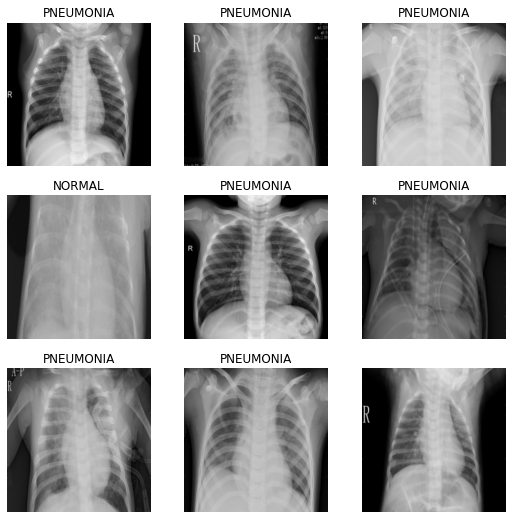

In [6]:
plt.figure(figsize=(9,9))
for i in range(1,10):
    data=next(iter(train_loader))
    rand_ind=torch.randint(0,batch_size-1,size=(1,)).item()
    label=data[1][rand_ind]
    image=data[0][rand_ind].permute(1,2,0)
    plt.title(train_data.classes[label.item()])
    plt.subplot(3,3,i)
    plt.axis(False)
    plt.imshow(image)
    

### Optimizer and Loss and Logdir

In [7]:
optimizer=torch.optim.Adam(model.parameters())
loss_fn=nn.CrossEntropyLoss()

In [8]:
log_dir = "./"+model_name+"feature_extractor_tensorboard"
writer = SummaryWriter(log_dir=log_dir)

def accuracy_fn(logits,true):
    return torch.eq(torch.argmax(torch.softmax(logits,dim=1),dim=1).squeeze(),true).sum().item()/len(logits)
    

### Testing model

In [9]:
model.eval()
with torch.inference_mode():
    x,y=next(iter(train_loader))
    x=x.to(device)
    y=y.to(device)
    logits=model(x)
    print(logits)
    print(loss_fn(logits.squeeze(),y))
    print(accuracy_fn(logits,y))

tensor([[-0.4934,  1.0646],
        [ 0.0381,  0.7557],
        [-0.3785,  1.1028],
        [-0.4604,  1.1097],
        [-0.4639,  1.2135],
        [-0.0125,  0.8157],
        [-0.8496,  1.4766],
        [-0.1292,  0.8787],
        [-0.3150,  0.3011],
        [-0.4107,  0.8644],
        [-0.2463,  1.0098],
        [-1.1254,  0.0903],
        [ 0.0928,  0.5852],
        [-0.1286,  0.1024],
        [-0.3950,  0.5776],
        [ 0.0246,  0.2081],
        [-0.2555,  0.6086],
        [-1.1550,  1.8493],
        [-1.9287,  1.5394],
        [-0.2744,  0.5493],
        [-0.6160,  0.0558],
        [-0.6828,  0.5907],
        [-0.6039,  0.0333],
        [-0.0973,  1.0716]], device='cuda:0')
tensor(0.8473, device='cuda:0')
0.7083333333333334


### Training Loop

In [10]:
epochs=10

train_accuracy=[]
test_accuracy=[]
train_loss=[]
test_loss=[]

for i in tqdm(range(epochs)):
    print("Training:")
    model.train()
    
    #Defining accuracy and loss for train and test data
    temp_train_accuracy=[]
    temp_test_accuracy=[]
    temp_train_loss=[]
    temp_test_loss=[]

    net_train_accuracy=0
    net_test_accuracy=0
    net_train_loss=0
    net_test_loss=0
    
    with tqdm(total=len(train_loader)) as pbar:
        for x,y in train_loader:
                x=x.to(device)
                y=y.to(device)
    
                #Calculating model output
                logits=model(x)
    
                #Reseting any old gradient values
                optimizer.zero_grad()
                loss=loss_fn(logits.squeeze(),y)

            
                #Track of metrics        
                accuracy_train=accuracy_fn(logits.type(torch.float32),y)
                temp_train_accuracy.append(accuracy_train)
                temp_train_loss.append(loss.item())
    
                #Back Propogation
                loss.backward()
            
                #Update Parameters
                optimizer.step()
            
                #Progress Bar Update
                pbar.update(1)
        pbar.close()
    #Tensorboard & Metrics for the dataset
    net_train_accuracy=sum(temp_train_accuracy)/len(temp_train_accuracy)
    net_train_loss=sum(temp_train_loss)/len(temp_train_loss)
    train_accuracy.append(net_train_accuracy)
    train_loss.append(net_train_loss)
    writer.add_scalar("Train Accuracy",net_train_accuracy,i)
    writer.add_scalar("Train Loss",net_train_loss,i)

    #Evaluation
    print("Testing:")
    model.eval()

    with tqdm(total=len(test_loader)) as pbar2:
        for x,y in test_loader:
            x=x.to(device)
            y=y.to(device)
            
            #Setting inference mode
            with torch.inference_mode():
                logits=model(x)
                loss=loss_fn(logits.squeeze().type(torch.float32),y)

                #Track of metrics
                accuracy_test=accuracy_fn(logits,y)
                temp_test_accuracy.append(accuracy_test)
                temp_test_loss.append(loss.item())

                #Progress Bar Update
                pbar2.update(1)
        pbar2.close()

    #Tensorboard & Metrics for the dataset
    net_test_accuracy=sum(temp_test_accuracy)/len(temp_test_accuracy)
    net_test_loss=sum(temp_test_loss)/len(temp_test_loss)
    test_accuracy.append(net_test_accuracy)
    test_loss.append(net_test_loss)
    writer.add_scalar("Test Accuracy",net_test_accuracy,i)
    writer.add_scalar("Test Loss",net_test_loss,i)

    #Saving the model
    try:
        os.makedirs(f"./{model_name}_feature_extractor/")
    except Exception as e:
        pass
    torch.save(model.state_dict(),f"./{model_name}_feature_extractor/checkpoint-{i+1}.pth")
    
    print(f"Epoch {i+1}:\nTrain Accuracy: {net_train_accuracy}  Train Loss: {net_train_loss}  Test Accuracy: {net_test_accuracy}  Test Loss: {net_test_loss}")
    print("\n")

  0%|          | 0/10 [00:00<?, ?it/s]

Training:


  0%|          | 0/183 [00:00<?, ?it/s]

Testing:


  0%|          | 0/61 [00:00<?, ?it/s]

Epoch 1:
Train Accuracy: 0.8142076502732242  Train Loss: 0.7243646025413373  Test Accuracy: 0.9234972677595626  Test Loss: 0.18943541991661805


Training:


  0%|          | 0/183 [00:00<?, ?it/s]

Testing:


  0%|          | 0/61 [00:00<?, ?it/s]

Epoch 2:
Train Accuracy: 0.9339708561020037  Train Loss: 0.1923748217395868  Test Accuracy: 0.9370218579234975  Test Loss: 0.16953819257314087


Training:


  0%|          | 0/183 [00:00<?, ?it/s]

Testing:


  0%|          | 0/61 [00:00<?, ?it/s]

Epoch 3:
Train Accuracy: 0.9458105646630237  Train Loss: 0.15759867722107496  Test Accuracy: 0.9371584699453551  Test Loss: 0.20050047576183178


Training:


  0%|          | 0/183 [00:00<?, ?it/s]

Testing:


  0%|          | 0/61 [00:00<?, ?it/s]

Epoch 4:
Train Accuracy: 0.9360200364298726  Train Loss: 0.1835337074923894  Test Accuracy: 0.9439890710382515  Test Loss: 0.16295497527834577


Training:


  0%|          | 0/183 [00:00<?, ?it/s]

Testing:


  0%|          | 0/61 [00:00<?, ?it/s]

Epoch 5:
Train Accuracy: 0.9565118397085612  Train Loss: 0.12047482283640897  Test Accuracy: 0.9527322404371582  Test Loss: 0.14119686637470713


Training:


  0%|          | 0/183 [00:00<?, ?it/s]

Testing:


  0%|          | 0/61 [00:00<?, ?it/s]

Epoch 6:
Train Accuracy: 0.9642531876138438  Train Loss: 0.10298305652403308  Test Accuracy: 0.9576502732240437  Test Loss: 0.11790426594174666


Training:


  0%|          | 0/183 [00:00<?, ?it/s]

Testing:


  0%|          | 0/61 [00:00<?, ?it/s]

Epoch 7:
Train Accuracy: 0.971994535519126  Train Loss: 0.0801451368196333  Test Accuracy: 0.9575136612021862  Test Loss: 0.11583267732477578


Training:


  0%|          | 0/183 [00:00<?, ?it/s]

Testing:


  0%|          | 0/61 [00:00<?, ?it/s]

Epoch 8:
Train Accuracy: 0.9767759562841535  Train Loss: 0.06262779610921422  Test Accuracy: 0.9528688524590165  Test Loss: 0.13838469295105973


Training:


  0%|          | 0/183 [00:00<?, ?it/s]

KeyboardInterrupt: 